# ** Run and then Ignore this**

In [1]:
#install import stuff, you need to login and give google permissions twice
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!pip install pandas==0.22

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 113597 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [2]:
#mount google drive
%cd
!mkdir -p drive
!google-drive-ocamlfuse drive

/root


In [3]:
#navigating your google drive and saving files inside.
%cd
%ls
%cd drive/
%mkdir github_st5220
%cd github_st5220
%rm -r ST5220
!git clone https://github.com/leexa90/ST5220.git
#download model parameters
%ls -lh */
%ls -lh
%cd ST5220
%ls -lh

/root
drive/
/root/drive
mkdir: cannot create directory ‘github_st5220’: File exists
/root/drive/github_st5220
Cloning into 'ST5220'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 26 (delta 9), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (26/26), done.
Checking out files: 100% (4/4), done.
total 62M
-rw-r--r-- 1 root root  56M Feb 12 08:09 2015.csv.zip
-rw-r--r-- 1 root root 6.7M Feb 12 08:09 codebook15_llcp.pdf
-rw-r--r-- 1 root root 1.4K Feb 12 08:09 README.md
-rw-r--r-- 1 root root  32K Feb 12 08:09 ST5220.ipynb
total 4.0K
drwxr-xr-x 2 root root 4.0K Feb 12 08:05 ST5220/
/root/drive/github_st5220/ST5220
total 62M
-rw-r--r-- 1 root root  56M Feb 12 08:09 2015.csv.zip
-rw-r--r-- 1 root root 6.7M Feb 12 08:09 codebook15_llcp.pdf
-rw-r--r-- 1 root root 1.4K Feb 12 08:09 README.md
-rw-r--r-- 1 root root  32K Feb 12 08:09 ST5220.ipynb


# **0. Figure out data types to efficiently load to memory**

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import gc
from itertools import combinations
#small dataset to figure out data types to load them more efficiently to memory
data= pd.read_csv('2015.csv.zip', compression='zip',sep=',',nrows=300)
dtypes = {}
for i in data.keys():
    if np.dtype(data[i]) != object:
        dtypes[i] = np.float32
    else: print i
   

IDATE
IMONTH
IDAY
IYEAR
PCDMDECN
EXACTOT1
EXACTOT2


# **1. Read entire dataset 400k datapoints, dummy variable for missing values in original dataset= -999**

In [2]:
data= pd.read_csv('2015.csv.zip', compression='zip',sep=',',nrows=500000,dtype=dtypes)


# Dummy value -999 for missing values
monthDay_to_int ={}
for i in range(32):
    str_i = str(i)
    if len(str_i) ==1:
        str_i = '0'+str_i
    monthDay_to_int["b'%s'" %str_i] = i
   
# changing datatype of day and month of survey
data['IMONTH']=data['IMONTH'].map(monthDay_to_int).astype(np.int32)
data['IDAY']=data['IDAY'].map(monthDay_to_int).fillna(15).astype(np.int32)

##this finds columns which only have one value
data_temp =data.fillna(-999) #fill a temporary datafile with -999 dummy value
y = data_temp.describe().iloc[2]!=0 #get cols with std ==0
cols = y[y==True].index
data = data[list(cols)]
gc.collect()

# approximate, if there are more than 20 unique values in column, column is quantitive,else qualitiave
num_of_unqiue_entries_per_column = data.apply(lambda x : len(pd.unique(x)))
quant_var = num_of_unqiue_entries_per_column[num_of_unqiue_entries_per_column>=20].index
quant_var = [x for x in quant_var if '_STATE' != x]
qual_var = [x for x in num_of_unqiue_entries_per_column[num_of_unqiue_entries_per_column<20].index if x!='_VEG23']# '_FRT16' is weird, explored later
data[qual_var] = data[qual_var].fillna(-999).astype(np.int32)
# not to fill quant_var because corelation will get affected by dummy var
#data[quant_var] = data[quant_var].fillna(-999).astype(np.float32)

# **2. Sample 6000 datapoints (data already collected by client)**

In [3]:
np.random.seed(1)
sample = data.sample(n=6000,replace=True)
sample['ori_index'] = sample.index
sample  = sample.reset_index(drop=True)
data_ori = data.copy(deep=True)

# **3. Cluster questions by correlation matrix and mutual information (normalized) and split them into 15 blocks, go to folder ST5220 in google drive for clear pic**

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage 
for i in quant_var:
    sample[i] = sample[i].fillna(np.mean(sample[i].dropna()))
corr = np.abs(sample[quant_var].corr().fillna(0).values)
 
from sklearn.metrics import normalized_mutual_info_score
mutual_info = np.zeros((len(qual_var),len(qual_var)))+1
for i in range(len(qual_var)):
    for j in range(i+1,len(qual_var)):
        mutual_info[i,j] = normalized_mutual_info_score(sample[qual_var[i]],sample[qual_var[j]])
        mutual_info[j,i] = mutual_info[i,j]
   

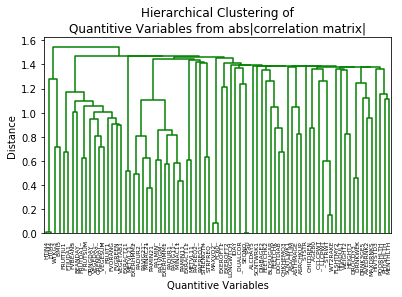

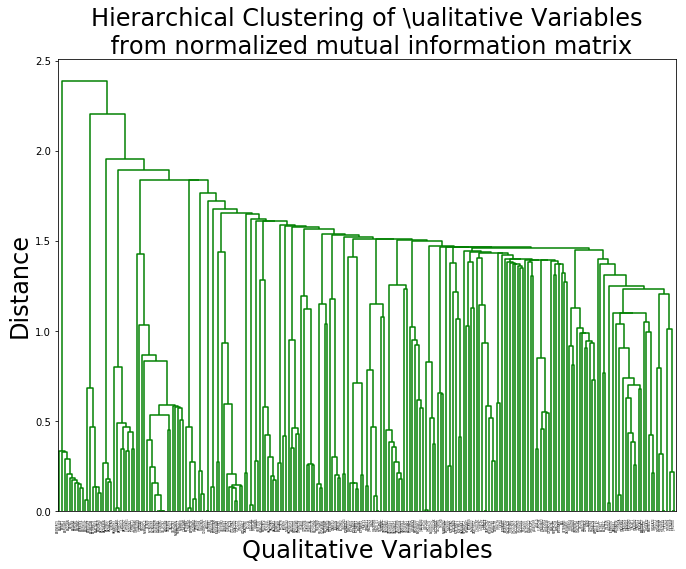

In [5]:

if True:
    num_block = 15
    import matplotlib.pyplot as plt
    plt.close()
    linked = linkage(corr[:,:], 'single')
    dendro  = dendrogram(linked, 
                orientation='top',
                labels=quant_var[:],
                distance_sort='descending',
                show_leaf_counts=True,color_threshold=15)
    import matplotlib.pyplot as plt
    plt.tight_layout(rect=[0.025, 0.025, .94, .94]);
    plt.title('Hierarchical Clustering of\nQuantitive Variables from abs|correlation matrix|')
    plt.ylabel('Distance');plt.xlabel('Quantitive Variables')
    plt.savefig('variables_clustering_by_corr_coef.png',dpi=300);plt.show()
    a=plt.imshow(corr[np.array(dendro['leaves']),:][:,np.array(dendro['leaves'])]);plt.colorbar(a);plt.close()
    df_corr = pd.DataFrame(corr,columns=quant_var)
    df_corr.to_csv('corr.csv',index=0)
    question_quant = {}
    for block in range(num_block):
        question_quant[block] = []
    for i in range(len(dendro['ivl'])): #place each question  into different blocks, using index from hierchal custering
        question_quant[i%num_block] += [dendro['ivl'][i],]
    #quanl var
    plt.close()
    plt.figure(figsize=(10,8))
    linked = linkage(mutual_info[:,:], 'single')
    dendro  = dendrogram(linked,
                orientation='top',
                labels=qual_var,
                distance_sort='descending',
                show_leaf_counts=True,color_threshold=15)
    import matplotlib.pyplot as plt
    plt.tight_layout(rect=[0.025, 0.025, .95, .92]);
    plt.title('Hierarchical Clustering of \ualitative Variables\n from normalized mutual information matrix',fontsize=24)
    plt.ylabel('Distance',fontsize=24);plt.xlabel('Qualitative Variables',fontsize=24)
    plt.xticks(range(0,len(dendro['ivl'])*10,10),dendro['ivl'],fontsize=2.5)
    plt.savefig('Qual_variables_clustering_by_corr_coef.png',dpi=500);plt.show()
    df_mutual_info = pd.DataFrame(mutual_info,columns=qual_var)
    df_mutual_info.to_csv('mutual_info.csv',index=0)
    question_qual = {}
    for block in range(num_block):
        question_qual[block] = []
    for i in range(len(dendro['ivl'])): #place each question  into different blocks, using index from hierchal custering
        question_qual[i%num_block] += [dendro['ivl'][i],]

# **4. Defining my own MICE(multiple imputation with chained equations) and KL-divergence formula**

In [ ]:
def MICE(df,qual_var,quant_var,iterations=10):
    from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
    from scipy.stats import mode
    # imputes dataframe using descision tree regressor/classifier. 
    #df =pandas dataframe
    #qual_var = categorical var list
    #qual_var= qualitative var list
    #n iterations
    '''NOTE:
    MISSING values due to split assigned = -99
    Missing values due to interviewee = -999,
     filling the -999 with the mode and mean respectively for qual and quant variable '''
#if True:
#    df = sample60k.copy(deep=True)
    missingid = (df==-99)  
    for i in qual_var : #ignore warning below, function is just about to be deprecated
        df = df.set_value(missingid[missingid[i]==True].index,i,mode(df[df[i]!=-99][i])[0][0])
    for i in quant_var :
        df = df.set_value(missingid[missingid[i]==True].index,i,np.mean(df[(df[i]!=-99)*(df[i]!=-999)][i]))
    df = df.fillna(-999) #some bug in code, this is a work around
    df_mean_mode_inpute =df.copy(deep=True)
    
    for n in range(iterations):
        print (n,'iterations'),
        for i in quant_var[:] :
            model = DecisionTreeRegressor(min_samples_split=30)
            feat = [x for x in quant_var if x != i] + list(qual_var)
            missing_index = missingid[missingid[i]==True].index
            present_index = missingid[missingid[i]==False].index
            model.fit(df.iloc[present_index][feat],df.iloc[present_index][i])
            missing_predictions = model.predict(df.iloc[missing_index][feat])
            df = df.set_value(missing_index,i,missing_predictions) #fill in missing values 
        for i in qual_var[:] :
            model = DecisionTreeClassifier(min_samples_split=30)
            feat = [x for x in qual_var if x != i] + list(quant_var)
            missing_index = missingid[missingid[i]==True].index
            present_index = missingid[missingid[i]==False].index
            model.fit(df.iloc[present_index][feat],df.iloc[present_index][i])
            missing_predictions = model.predict(df.iloc[missing_index][feat])
            df = df.set_value(missing_index,i,missing_predictions)
        gc.collect()
    print ('finished running with imputed values')
    return df,df_mean_mode_inpute

def KL_divergence(data1,data2,feat):
    a = Counter(data1[feat]) #get discrete discrtirbution in terms of counts
    b = Counter(data2[feat])
    #normalzie the dsitribution, and fill in empty entries with small dummy number =0.01
    for j in np.unique(a.keys()+b.keys()):
        if j in a.keys():
            a[j] = a[j]*1./len(data1)
        else: a[j] = 0.01
        if j in b.keys():
            b[j] = b[j]*1./len(data2)
        else: b[j] = 0.01    
    KL_div = 0
    #print a,b
    for j in np.unique(a.keys()+b.keys()):
        KL_div += (a[j])*np.log(a[j]/b[j])
    return KL_div 

# **5. Run experiments across different sample size/question block size and compare the kl-divergence and root-meansquare error (normalized by standard deviation)**

Run time ~ 8 hours

dummary variables : 
-999 are empty responses given 
,-99 are questions not attempted due to split questionair design


In [ ]:
if True:
    data[quant_var] = data[quant_var].fillna(-999).astype(np.float32)
    data = data.fillna(-999)
    result_MICE= {}
    samplesize=6000
    np.random.seed(5220)
    for num_of_blocks in [2,3,4]:  #2,3,4 correpsond to 40,60,80 questions in survey
      for samplesize in [6000,12000,25000,50000,100000][:]:
          print 'calculating, samplesize:',samplesize,'num_blocks:',num_of_blocks,
          sample60k = data.sample(n=samplesize,replace=True)
          sample60k['ori_index'] = sample60k.index
          #sort by state, to strafiy sampling by state to increase percision
          #ref Increasing Survey Statistics Precision Using Split Questionnaire Design: An Application of Small Area Estimation
          sample60k = sample60k.sort_values('_STATE').reset_index(drop=True) 
          Combinations_nC3 = list(combinations(range(num_block),num_of_blocks)) #nC3 combinations of the number of blocks. 
          dictt_interger_to_combinations = {}
          np.random.shuffle(Combinations_nC3)
          for i in range(len(Combinations_nC3)):
              dictt_interger_to_combinations[i] = Combinations_nC3[i]
          sample60k['block'] = (sample60k.index%len(Combinations_nC3))
          sample60k['block']=sample60k['block'].map(dictt_interger_to_combinations)
          sample60k_ori = sample60k.copy(deep=True)#for validation, 'correct' answer
          
          #Initalize datafile with -99, where -99 denotes missing value due to survey split. 
          sample60k[sample60k.keys()[:-2]] = sample60k[sample60k.keys()[:-2]]*0-99
          sample60k['_STATE'] = sample60k_ori ['_STATE']
          sample60k['ori_index'] = sample60k_ori['ori_index']
          sample60k['block'] = sample60k_ori ['block']
          for blockcomb in Combinations_nC3:
              questions_answered = []
              for block in blockcomb : #blockcomb is tuple
                  questions_answered += [x for x in  question_quant[block]]
                  questions_answered += [x for x in  question_qual[block]]
              block_index = sample60k[sample60k['block']==blockcomb].index
              sample60k = sample60k.set_value(block_index,
                                               questions_answered,
                                               sample60k_ori[sample60k_ori['block']==blockcomb][questions_answered])
          imputed60k,imputed60k_mean_mode = MICE(df = sample60k.copy(deep=True),qual_var = qual_var,quant_var = quant_var,iterations=10)
          #normalized root mean squared error
          quant_result1 = np.mean(np.mean(((imputed60k[quant_var]-sample60k_ori[quant_var])/np.std(sample60k_ori[quant_var],0))**2,0)**.5)
          #average absolute percentage error in mean and var
          quant_result2 = np.mean(abs((imputed60k[quant_var].describe().iloc[1:3]-sample60k_ori[quant_var].describe().iloc[1:3])/sample60k_ori[quant_var].describe().iloc[1:3]),1)**2
          #KL divergence  
          qual_result = np.mean(map(lambda x : KL_divergence(imputed60k,data,x), qual_var[:]) )
          result_MICE[(samplesize,num_of_blocks)]= (quant_result1,quant_result2,qual_result);
          print ('results:',(quant_result1,quant_result2,qual_result))

calculating, samplesize: 600 num_blocks: 2

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:37: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python2.7/dist-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


 (0, 'iterations')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


 (1, 'iterations') (2, 'iterations') (3, 'iterations') (4, 'iterations') (5, 'iterations') (6, 'iterations') (7, 'iterations') (8, 'iterations') (9, 'iterations') finished running with imputed values
('results:', (1.2777021, mean    1.902265
std     0.115436
dtype: float64, 0.19988637247369168))
calculating, samplesize: 1200 num_blocks: 2 (0, 'iterations')

# Print results in friendly manner

In [ ]:
for i in result_MICE.keys():
    print 'samplesize',i[0],'num_of_blocks',i[1]
    print 'average absolute percentage error in mean and var',result_MICE[i][1][0],result_MICE[i][1][1]
    print 'KL divergence',result_MICE[i][2],'\n\n\n'
    
    

In [4]:
results_CSV = pd.read_csv('results.csv')
results_CSV[results_CSV.keys()[:6]]

,Unnamed: 0,Survey Sample Size,Num of Blocks,MAPE of survey Mean (quantitative Variables),MAPE of survey Standard deviation (quantitative Variables),KL-divergence Of categorical Variable
0,0,6000,2,0.352,0.043,0.111
1,1,6000,3,0.042,0.023,0.085
2,2,6000,4,0.038,0.014,0.080
3,3,12000,2,0.199,0.056,0.099
4,4,12000,3,0.047,0.018,0.074
5,5,12000,4,0.027,0.011,0.064
6,6,25000,2,0.172,0.039,0.075
7,7,25000,3,0.058,0.019,0.062
8,8,25000,4,0.026,0.011,0.052
9,9,50000,2,0.180,0.039,0.069


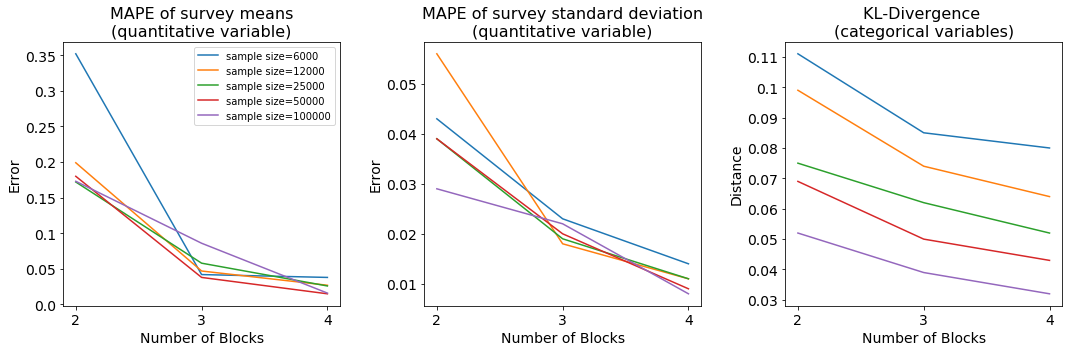

In [65]:
import matplotlib.pyplot as plt
f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))
#results_CSV.groupby([results_CSV.keys()[1],results_CSV.keys()[2]])[results_CSV.keys()[3:6]].apply(np.mean)
for i in [6000,12000,25000,50000,100000]:
    a = results_CSV[results_CSV[results_CSV.keys()[1]] ==i][results_CSV.keys()[3:6]].values
    ax1.plot([2,3,4],a.T[0],label='sample size='+str(i))
    ax2.plot([2,3,4],a.T[1])
    ax3.plot([2,3,4],a.T[2])
ax1.legend()
ax1.set_title('MAPE of survey means\n(quantitative variable)',fontsize=16)
ax2.set_title('MAPE of survey standard deviation\n(quantitative variable)',fontsize=16)
ax3.set_title('KL-Divergence \n(categorical variables)',fontsize=16)
ax1.set_xticks([2,3,4])
ax1.set_xticklabels([2,3,4],fontsize=14)
ax1.set_xlabel('Number of Blocks',fontsize=14)
ax1.set_ylabel('Error',fontsize=14)
ax2.set_ylabel('Error',fontsize=14)
ax3.set_ylabel('Distance',fontsize=14)
ax2.set_xticks([2,3,4])
ax2.set_xticklabels([2,3,4],fontsize=14)
ax2.set_xlabel('Number of Blocks',fontsize=14)
ax3.set_xticks([2,3,4])
ax3.set_xticklabels([2,3,4],fontsize=14)
ax1.set_yticklabels(map(lambda x : np.round(x,2),ax1.get_yticks()),fontsize=14)
ax2.set_yticklabels(map(lambda x : np.round(x,2),ax2.get_yticks()),fontsize=14)
ax3.set_yticklabels(map(lambda x : np.round(x,2),ax3.get_yticks()),fontsize=14)
ax3.set_xlabel('Number of Blocks',fontsize=14)
plt.savefig('Results.png',dpi=300);plt.tight_layout()
plt.show()